In [8]:
import pandas as pd
import geopandas as gpd
#import requests
#import os
#import shutil
import matplotlib.pyplot as plt
#import sys
import numpy as np
#import datetime
#import folium
#import shapely
import scipy
#import skimage
from shapely.geometry import Polygon, MultiPolygon
#from shapely.affinity import translate, scale
import datetime

## Load supporting data

In [2]:
COUNTY_LIST = {
    "Delaware":"041",
    "Fairfield":"045",
    "Fayette":"047",
    "Franklin":"049",
    "Hocking":"073",
    "Knox":"083",
    "Licking":"089",
    "Logan":"091",
    "Madison":"097",
    "Marion":"101",
    "Morrow":"117",
    "Perry":"127",
    "Pickaway":"129",
    "Ross":"141",
    "Union":"159"
}

walk_speed = 2.5 * 1.6  # km/h = mph * 1.6 km/mile
bike_speed = 15 * 1.6  # km/h = mph * 1.6 km/mile

In [3]:
region = gpd.read_file("./temp_data/region.shp")
region = region.to_crs(epsg=4326)
counties = gpd.read_file("./temp_data/counties.shp")
counties = counties.to_crs(epsg=4326)
tracts = gpd.read_file("./temp_data/tracts.shp")
tracts = tracts.to_crs(epsg=4326)
site = gpd.read_file("./input_data/site/site.shp")
site = site.to_crs(epsg=4326)
park_and_ride = gpd.read_file("./temp_data/park_and_ride.shp")
park_and_ride = park_and_ride.to_crs(epsg=4326)
points = gpd.read_file("./temp_data/points.shp")
points = points.to_crs(epsg=4326)
tract_points = gpd.read_file("./temp_data/tract_points.shp")
tract_points = tract_points.to_crs(epsg=4326)
blocks = gpd.read_file("./temp_data/blocks.shp")
blocks = blocks.to_crs(epsg=4326)

<AxesSubplot:>

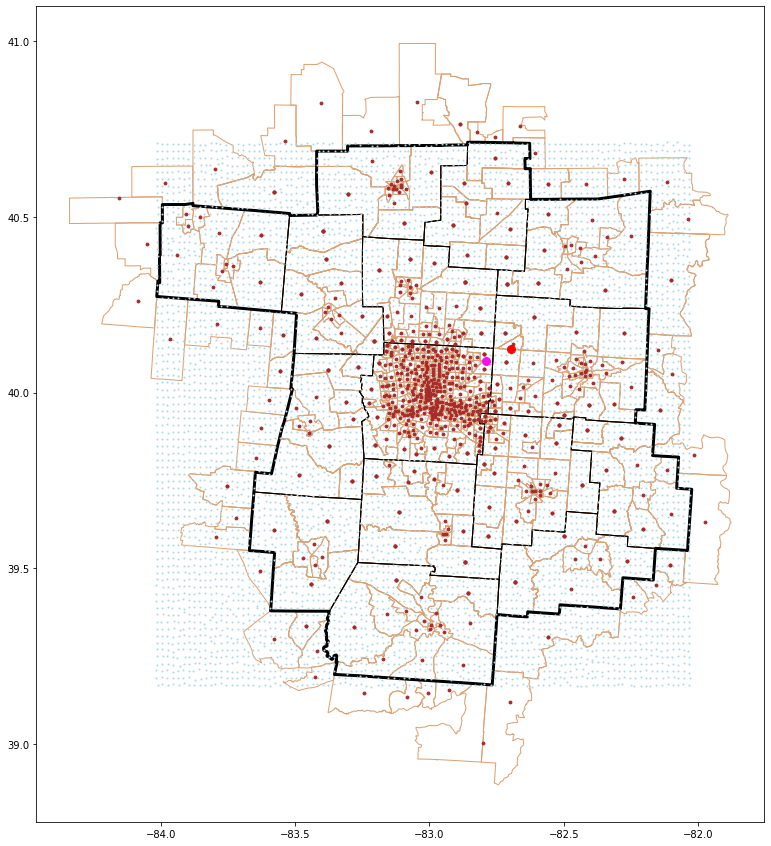

In [4]:
ax = tracts.plot(edgecolor="#dda071", facecolor="none", figsize=(15,15))
counties.plot(ax=ax, edgecolor="black", facecolor="none")
region.plot(ax=ax, linewidth=3, edgecolor="black", facecolor="none")
points.plot(ax=ax, color="lightblue", markersize=1)
tract_points.plot(ax=ax, color="brown", markersize=8)
site.plot(ax=ax, color="red", markersize=64)
park_and_ride.plot(ax=ax, color="#fc0cf4", markersize=64)

## Compute travel times between origin and destinations

In [5]:
ttm = pd.read_csv("./output_data/ttm_CAR_outbound_neighborhoods.csv")
ttm["fromId"] = ttm["fromId"].astype("string")
ttm["toId"] = ttm["toId"].astype("string")
ttm_points = tract_points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
ttm_points.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

## Create travel time isochrones

### Car

In [155]:
ttm = pd.read_csv("output_data/ttm_CAR_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [157]:
ttm.head()

fromId  toId  travel_time
0       1   161           89
1       1   352           87
2       1   450           89
3       1   451           86
4       1   452           87

In [9]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [10]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [11]:
tightgrid["travel_time"] = z

<AxesSubplot:>

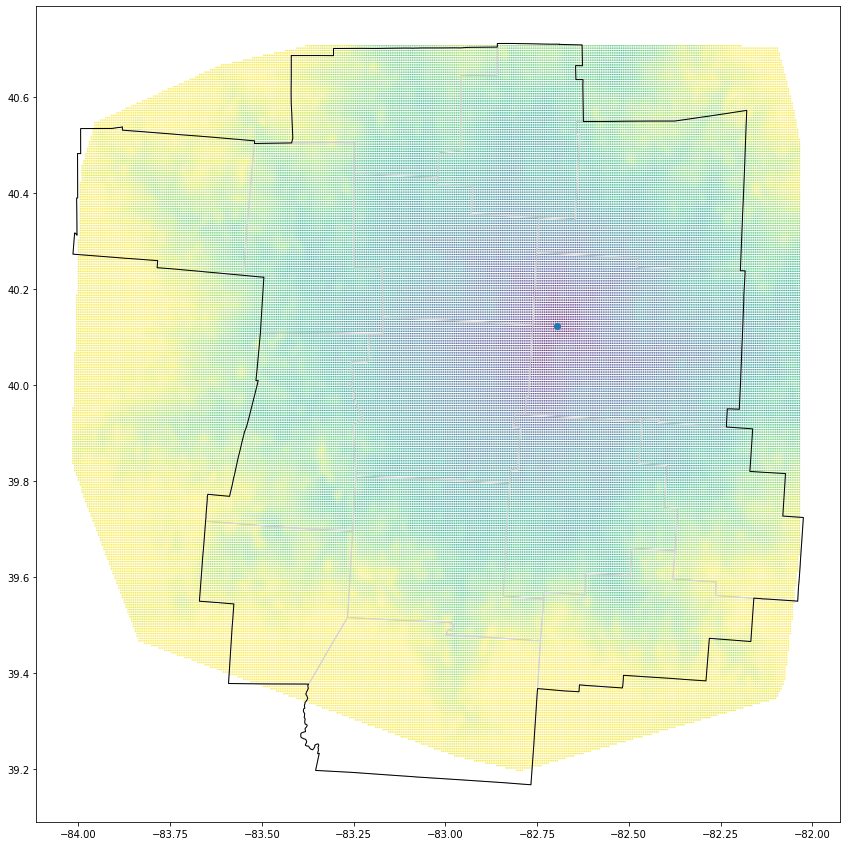

In [12]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [13]:
Z = z.reshape((len(y),len(x)))

In [14]:
%%capture
levels = [10,20,30,40,50,60,70,80,90]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_CAR.shp", index=False)

In [15]:
isochrones

travel_time                                           geometry
8           90  MULTIPOLYGON (((-82.80476 39.19777, -82.79976 ...
7           80  MULTIPOLYGON (((-82.98976 39.34777, -82.98476 ...
6           70  MULTIPOLYGON (((-82.97476 39.45457, -82.96976 ...
5           60  MULTIPOLYGON (((-82.51476 39.55590, -82.51321 ...
4           50  MULTIPOLYGON (((-82.67476 39.66940, -82.67030 ...
3           40  MULTIPOLYGON (((-82.57476 39.78731, -82.57474 ...
2           30  MULTIPOLYGON (((-82.76976 39.89250, -82.76476 ...
1           20  MULTIPOLYGON (((-82.73476 39.93566, -82.72976 ...
0           10  MULTIPOLYGON (((-82.73476 40.02833, -82.73144 ...

In [16]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Walk + Bus

In [17]:
ttm = pd.read_csv("output_data/ttm_WALK-TRANSIT-WALK_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [18]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [19]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [20]:
tightgrid["travel_time"] = z

<AxesSubplot:>

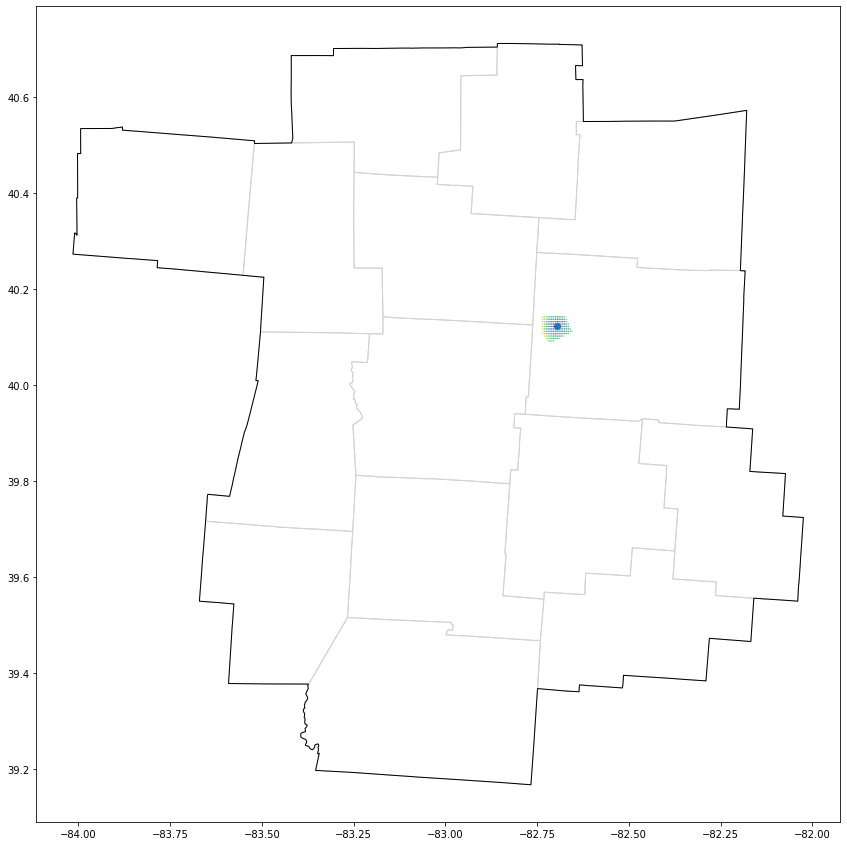

In [21]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [22]:
Z = z.reshape((len(y),len(x)))

In [23]:
%%capture
levels = [10,20,30,40,50,60,70,80,90]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_WALK_BUS.shp", index=False)

In [24]:
isochrones

travel_time                                           geometry
7           90  MULTIPOLYGON (((-82.71976 40.09277, -82.71476 ...
6           80  MULTIPOLYGON (((-82.71976 40.09277, -82.71476 ...
5           70  MULTIPOLYGON (((-82.71976 40.09748, -82.71711 ...
4           60  MULTIPOLYGON (((-82.70976 40.09680, -82.70476 ...
3           50  MULTIPOLYGON (((-82.69976 40.10260, -82.69927 ...
2           40  MULTIPOLYGON (((-82.69976 40.10993, -82.69476 ...
1           30  MULTIPOLYGON (((-82.69476 40.11554, -82.69126 ...
0           20  MULTIPOLYGON (((-82.69976 40.12571, -82.69476 ...

In [25]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Bike + Bus

In [60]:
ttm = pd.read_csv("output_data/ttm_BIKE-TRANSIT-BIKE_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [61]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [62]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [63]:
tightgrid["travel_time"] = z

<AxesSubplot:>

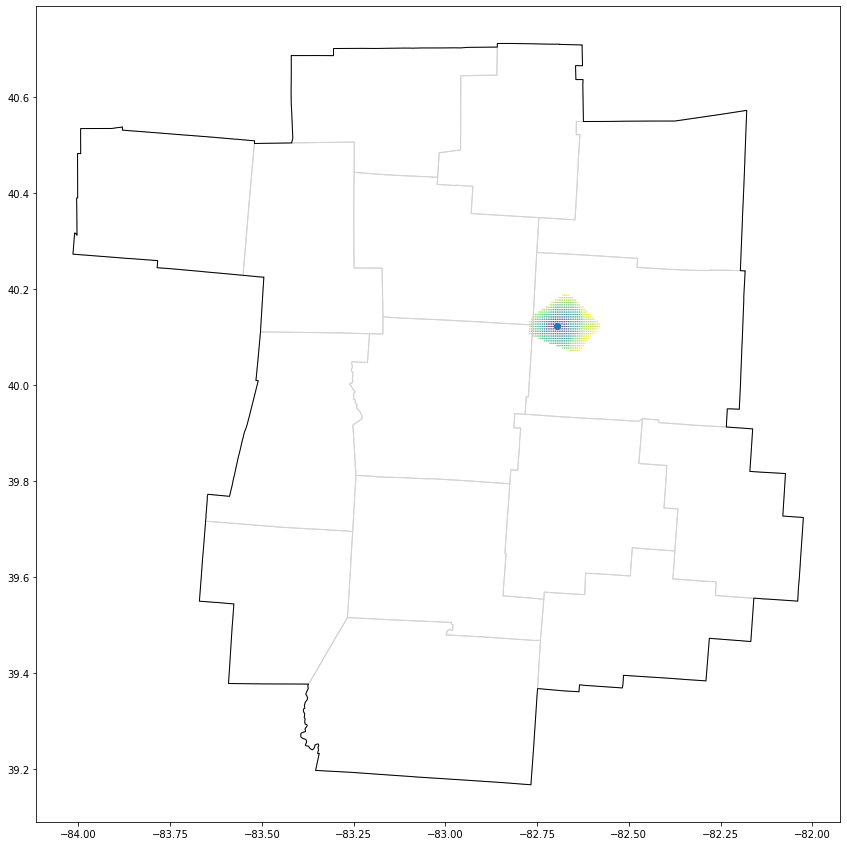

In [64]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [65]:
Z = z.reshape((len(y),len(x)))

In [66]:
%%capture
levels = [10,20,30,40,50,60,70,80,90]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_BIKE_BUS.shp", index=False)

In [67]:
isochrones

travel_time                                           geometry
7           90  MULTIPOLYGON (((-82.65976 40.07277, -82.65476 ...
6           80  MULTIPOLYGON (((-82.65976 40.07360, -82.65476 ...
5           70  MULTIPOLYGON (((-82.67976 40.08103, -82.67476 ...
4           60  MULTIPOLYGON (((-82.68976 40.08747, -82.68476 ...
3           50  MULTIPOLYGON (((-82.69476 40.09639, -82.68976 ...
2           40  MULTIPOLYGON (((-82.68476 40.10267, -82.67976 ...
1           30  MULTIPOLYGON (((-82.68976 40.11263, -82.68476 ...
0           20  MULTIPOLYGON (((-82.71976 40.12209, -82.71476 ...

In [68]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

### Shuttle + Bus

In [51]:
ttm = pd.read_csv("output_data/ttm_SHUTTLE-TRANSIT-WALK_outbound_90.csv")
ttm["fromId"] = ttm["fromId"].astype("int")
ttm["toId"] = ttm["toId"].astype("int")
ttm_points = points.copy() \
    .merge(ttm, left_on="id", right_on="toId")

In [52]:
GRIDSPACING = 0.005

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

coords = np.column_stack((X.ravel(), Y.ravel()))

z = scipy.interpolate.griddata(np.array(list(zip(ttm_points["geometry"].x,ttm_points["geometry"].y))), list(ttm_points["travel_time"]), coords, method="linear")

In [53]:
tightgrid = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(X.ravel(), Y.ravel()))

In [54]:
tightgrid["travel_time"] = z

<AxesSubplot:>

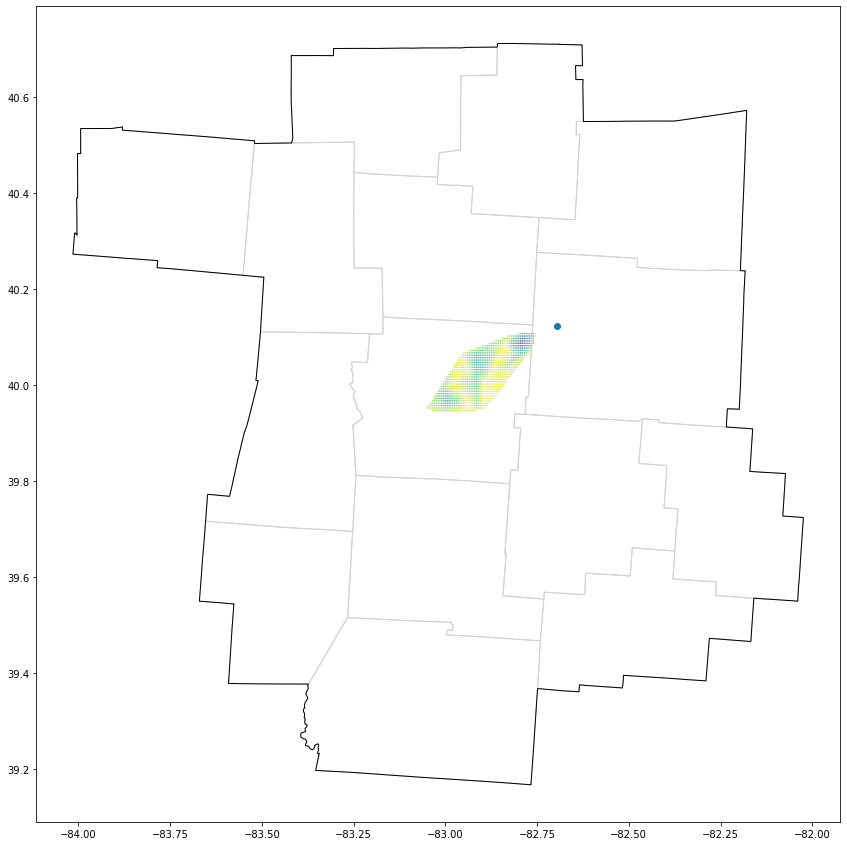

In [55]:
ax = tightgrid.plot(column="travel_time", cmap="viridis", markersize=0.2, figsize=(15,15))
counties.plot(ax=ax, edgecolor="lightgrey", facecolor="none")
region.plot(ax=ax, edgecolor="black", facecolor="none")
site.plot(ax=ax)

In [56]:
Z = z.reshape((len(y),len(x)))

In [57]:
%%capture
levels = [10,20,30,40,50,60,70,80]
contourList = []
i = 0
for i in range(0, len(levels)):
    contours = plt.contourf(X,Y,Z, [0, levels[i]])
    thisContourList = []
    collection = contours.collections[0]
    if(len(collection.get_paths()) == 0):
        continue
    for path in collection.get_paths():
        for polygon in path.to_polygons(): 
            thisContourList.append(Polygon(polygon))
    contourList.append({
        "travel_time": levels[i],
        "geometry": MultiPolygon(thisContourList),
    })

# Create the GeoDataFrame
isochrones = gpd.GeoDataFrame.from_records(contourList).sort_values("travel_time", ascending=False)
isochrones.crs = "epsg:4326"
isochrones.to_file("./output_data/isochrones_SHUTTLE_TRANSIT_WALK.shp", index=False)

In [58]:
isochrones

travel_time                                           geometry
6           80  MULTIPOLYGON (((-83.03476 39.94777, -83.02976 ...
5           70  MULTIPOLYGON (((-83.02976 39.95277, -83.02476 ...
4           60  MULTIPOLYGON (((-82.99476 39.95439, -82.98976 ...
3           50  MULTIPOLYGON (((-82.99976 39.96708, -82.99476 ...
2           40  MULTIPOLYGON (((-82.79976 40.07618, -82.79476 ...
1           30  MULTIPOLYGON (((-82.79976 40.08190, -82.79476 ...
0           20  MULTIPOLYGON (((-82.79476 40.08490, -82.79102 ...

In [59]:
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
isochrones.explore("travel_time", m=m, cmap="viridis")
site.explore(m=m, style_kwds={"fillOpacity":1}, marker_kwds={"radius": 4, "color":"red", "fill":"red"})

## Compute accessibility

In [115]:
block_centroids = blocks.to_crs(epsg=3735).copy()
block_centroids["geometry"] = block_centroids["geometry"].centroid
block_centroids["TOTALPOP"] = block_centroids["TOTALPOP"].astype("int")
block_centroids.head()

GEOID COUNTYFP  TOTALPOP                        geometry
0  390970412003030      097        27  POINT (1751580.610 625132.603)
1  390970412003005      097        94  POINT (1750019.327 627203.438)
2  390970412002014      097         0  POINT (1755442.690 626080.351)
3  390970411004019      097         1  POINT (1717688.092 690977.420)
4  390970413001057      097         1  POINT (1664365.458 642473.125)

In [102]:
isochrones_car = gpd.read_file("./output_data/isochrones_CAR.shp").to_crs(epsg=3735)
isochrones_transit = gpd.read_file("./output_data/isochrones_SHUTTLE_TRANSIT_WALK.shp").to_crs(epsg=3735)
budget_car = isochrones_car.loc[isochrones_car["travel_tim"] == 60]
budget_transit = isochrones_transit.loc[isochrones_transit["travel_tim"] == 80]

<AxesSubplot:>

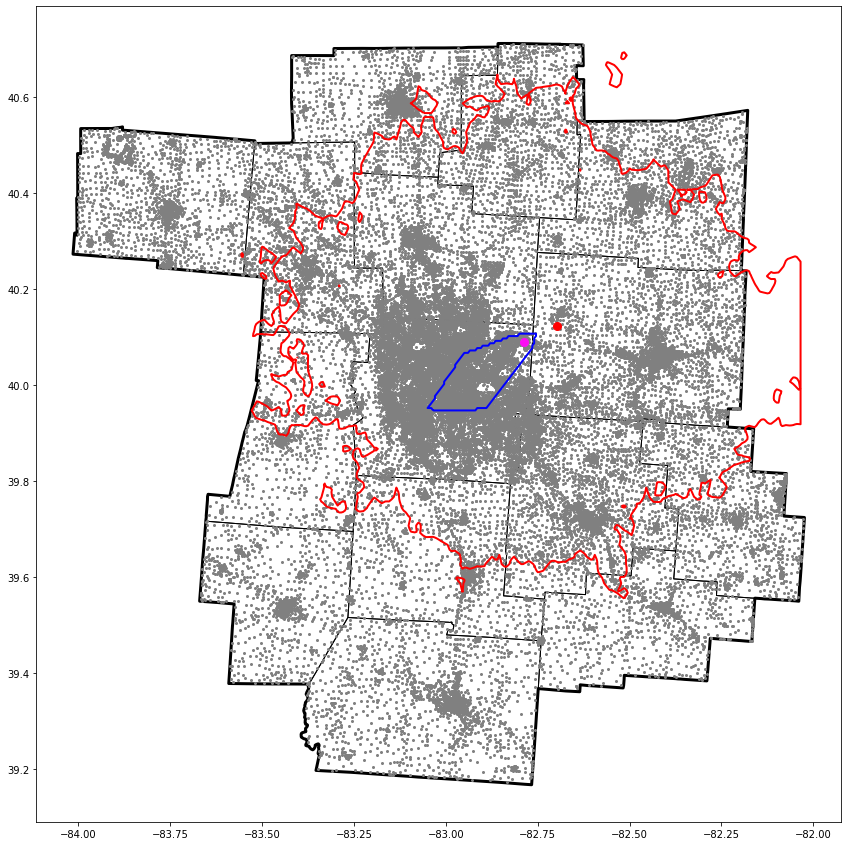

In [158]:
ax = counties.plot(edgecolor="black", facecolor="none", figsize=(15,15))
region.plot(ax=ax, linewidth=3, edgecolor="black", facecolor="none")
block_centroids.to_crs(epsg=4326).plot(ax=ax, color="grey", markersize=4)
site.plot(ax=ax, color="red", markersize=64)
park_and_ride.plot(ax=ax, color="#fc0cf4", markersize=64)
budget_car.to_crs(epsg=4326).plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2, legend=True)
budget_transit.to_crs(epsg=4326).plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=2, legend=True)

In [126]:
opportunities_car = gpd.sjoin(block_centroids, budget_car, how='right', predicate='intersects', lsuffix='left', rsuffix='right')
opportunities_transit = gpd.sjoin(block_centroids, budget_transit, how='right', predicate='intersects', lsuffix='left', rsuffix='right')

In [142]:
opportunities_stats = pd.DataFrame.from_dict({
        "Car": {
            "Population served": opportunities_car["TOTALPOP"].sum(),
            "Area covered (sq. mi.)": budget_car.area.sum()/(5280**2)
        },
        "Transit with shuttle": {
            "Population served": opportunities_transit["TOTALPOP"].sum(),
            "Area covered (sq. mi.)": budget_transit.area.sum()/(5280**2)
        }
    }, 
    orient="index")
opportunities_stats["Population/Area"] = opportunities_stats["Population served"] / opportunities_stats["Area covered (sq. mi.)"]
opportunities_stats.to_csv("./output_data/opportunities_stats.csv")
opportunities_stats

Population served  Area covered (sq. mi.)  \
Car                             2057480             3616.084334   
Transit with shuttle             301040               89.158237   

                      Population/Area  
Car                        568.980093  
Transit with shuttle      3376.468744

<AxesSubplot:>

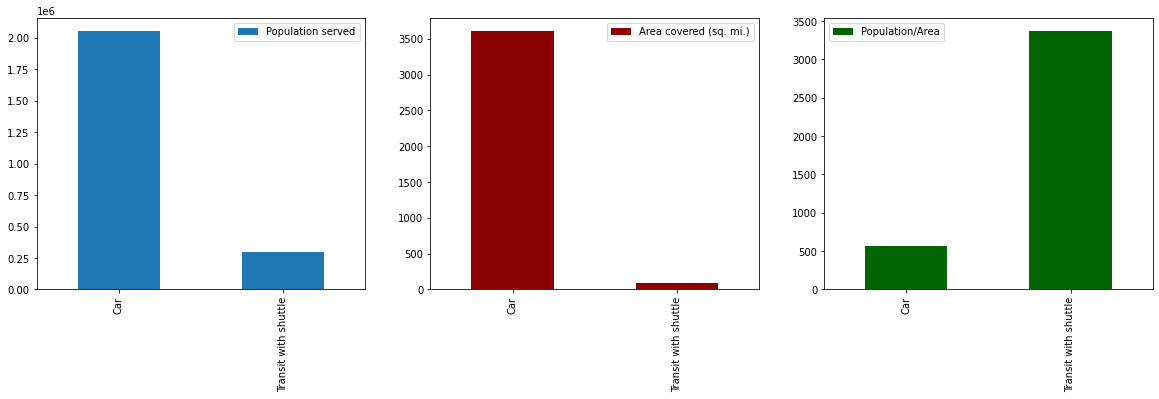

In [154]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
opportunities_stats.plot.bar(ax=ax[0], y="Population served")
opportunities_stats.plot.bar(ax=ax[1], y="Area covered (sq. mi.)", color="darkred")
opportunities_stats.plot.bar(ax=ax[2], y="Population/Area", color="darkgreen")

## Create detailed itineraries

In [44]:
destination = "39049007820"   # OSU Mariott
itineraries = gpd.read_file("./output_data/itineraries_ANY_toconference_150.shp")
singleItinerary = itineraries.loc[itineraries["option"] == 2].copy()
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = tract_points.loc[tract_points["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="CartoDB positron", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 88.65 total, 80.51666666666665 travel, 8.133333333333333 wait
Walking distance (meters): 504
Biking distance (meters): 0


In [48]:
park_and_ride.dtypes

id             int64
geometry    geometry
dtype: object

In [50]:
itineraries = gpd.read_file("./output_data/itineraries_SHUTTLE_firstmile.shp")
destination = 0
singleItinerary = itineraries.loc[itineraries["toId"] == str(destination)].copy()
singleItinerary["mode"] = singleItinerary["mode"].str.replace("CAR","SHUTTLE")
singleItinerary["LABEL"] = singleItinerary["segment"].astype("str")  + " / " + singleItinerary["mode"]
print("Trip time (min): {} total, {} travel, {} wait".format(singleItinerary["ttl_drt"].max(), singleItinerary["sgmnt_d"].sum(), singleItinerary["wait"].sum()))
print("Walking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "WALK", "distanc"].sum()))
print("Biking distance (meters): {}".format(singleItinerary.loc[singleItinerary["mode"] == "BICYCLE", "distanc"].sum()))
destinationPoint = park_and_ride.loc[park_and_ride["id"] == destination]
m = singleItinerary.explore(column="LABEL", cmap="rainbow", tiles="CartoDB positron", style_kwds={"weight":8}, legend=True)
site.explore(m=m)
destinationPoint.explore(m=m)

Trip time (min): 13.3 total, 13.3 travel, 0.0 wait
Walking distance (meters): 0
Biking distance (meters): 0


## Appendix: Create grid of destination points

In [ ]:
raise RuntimeError

In [ ]:
GRIDSPACING = 0.02

bounds = region.total_bounds

xmin = bounds[0]
xmax = bounds[2]
ymin = bounds[1]
ymax = bounds[3]

x = np.arange(xmin, xmax, GRIDSPACING)

y = np.arange(ymin, ymax, GRIDSPACING)

X,Y = np.meshgrid(x,y)

points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(X.ravel(), Y.ravel()))
points = points.reset_index().rename(columns={"index":"id"})

points.to_file("./temp_data/points_raw.shp")

ax = points.plot(markersize=0.1, figsize=(10,10))
region.plot(ax=ax, edgecolor="black", facecolor="none")

# Final step: In ArcPro, run Default.tbx\r5prep to snap grid points to OSM road network

## Appendix: Create regional county boundaries dataset

In [ ]:
raise RuntimeError

In [ ]:
counties_all = gpd.read_file("./input_data/counties/cb_2021_us_county_500k.shp")

In [ ]:
counties_region = counties_all.loc[(counties_all["STATE_NAME"] == "Ohio") & (counties_all["COUNTYFP"].isin(COUNTY_LIST.values()))]

In [ ]:
ax = counties_region.plot(figsize=(10,10))

In [ ]:
counties_region.to_file("./temp_data/counties.shp")

## Appendix: Create region boundary dataset

In [ ]:
raise RuntimeError

In [ ]:
region = counties_region.dissolve()
region.plot()

In [ ]:
region.to_file("./temp_data/region.shp")

## Appendix: Create tract boundaries and centroids datasets

In [ ]:
tracts_all = gpd.read_file("./input_data/tracts/tl_2021_39_tract.shp")

tracts_region = gpd.sjoin(tracts_all.to_crs(epsg=3735), counties_region[["COUNTYFP","geometry"]].to_crs(epsg=3735), how='left', predicate='intersects', lsuffix='left', rsuffix='right')

tracts_region = tracts_region.loc[tracts_region["COUNTYFP_right"].notna()] \
    .filter(axis="columns", items=["GEOID", "COUNTYFP_left", "geometry"]) \
    .rename(columns={
        "GEOID_left":"GEOID",
        "COUNTYFP_left":"COUNTYFP"
    }) \
    .to_crs(epsg=4326)

tracts_region["centroid"] = tracts_region.to_crs(epsg=3735).centroid.to_crs(epsg=4326)

tract_centroids = gpd.GeoDataFrame(data=tracts_region.drop(columns=["geometry"]), geometry=tracts_region["centroid"])
tract_centroids = tract_centroids \
    .drop(columns=["centroid"]) \
    .rename(columns={"GEOID":"id"})

tracts_region = tracts_region.drop(columns=["centroid"])

tracts_region.to_file("./temp_data/tracts.shp")
tract_centroids.to_file("./temp_data/tract_points_raw.shp")

ax = tracts_region.plot(figsize=(15,15))
tract_centroids.plot(ax=ax, color="black", markersize=4)
counties_region.plot(ax=ax, edgecolor="black", facecolor="none")

# Final step: In ArcPro, run Default.tbx\r5prep to snap tract centroids to OSM road network

## Appendix: Download census population data

In [ ]:
raise RuntimeError

In [ ]:
blocks_raw = gpd.read_file("./input_data/blocks/tl_2021_39_tabblock20.shp", dtype="object")

In [ ]:
blocks = blocks_raw.copy()

In [ ]:
blocks = blocks.loc[blocks["COUNTYFP20"].isin(COUNTY_LIST.values())]
blocks = blocks \
    .rename(columns={
        "COUNTYFP20":"COUNTYFP",
        "GEOID20":"GEOID"
    }) \
    .filter(axis="columns", items=["GEOID", "COUNTYFP", "geometry"])                                   

In [ ]:
r = requests.get("https://api.census.gov/data/2020/dec/pl?get=GEO_ID,P1_001N&for=block:*&in=state:39%20county:{}".format(",".join(COUNTY_LIST.values())))
records = r.json()
columns = records.pop(0)
blockData = pd.DataFrame.from_records(records, columns=columns)
blockData.to_csv("./input_data/blocks/blockData.csv", index=False)

In [ ]:
blockData = pd.read_csv("./input_data/blocks/blockData.csv", dtype="object")
blockData = blockData.loc[blockData["county"].isin(COUNTY_LIST.values())]
blockData["GEOID"] = blockData["GEO_ID"].apply(lambda x:x.split("US")[1])
blockData = blockData \
    .rename(columns={
        "county":"COUNTYFP",
        "P1_001N":"TOTALPOP"
    }) \
    .filter(axis="columns", items=["GEOID", "COUNTYFP", "TOTALPOP"])                                   

In [ ]:
blocks = blocks \
    .merge(blockData, left_on="GEOID", right_on="GEOID") \
    .filter(axis="columns", items=["GEOID","COUNTYFP_x", "TOTALPOP", "geometry"]) \
    .rename(columns={"COUNTYFP_x":"COUNTYFP"})
blocks.to_file("./temp_data/blocks.shp")
blocks.head()

## Appendix: Review sample location routing results

In [ ]:
temp = pd.read_csv("./input_data/sample_locations.csv")
sample_locations = gpd.GeoDataFrame(data=temp, geometry=gpd.GeoSeries.from_xy(x=temp["lon"], y=temp["lat"]))

In [ ]:
temp = pd.read_csv("./output_data/ttm_sample_locations_car.csv")
travel_times_car = sample_locations.merge(temp, left_on="id", right_on="toId")
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
travel_times_car.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})

In [ ]:
temp = pd.read_csv("./output_data/ttm_sample_locations_bike.csv")
travel_times_bike = sample_locations.merge(temp, left_on="id", right_on="toId")
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
travel_times_bike.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})

In [ ]:
temp = pd.read_csv("./output_data/ttm_sample_locations_transit.csv")
travel_times_transit = sample_locations.merge(temp, left_on="id", right_on="toId")
m = counties.explore(tiles="CartoDB positron", style_kwds={"color":"black", "weight":2, "fill":False})
travel_times_transit.explore("travel_time", m=m, cmap="viridis", marker_kwds={"radius": 6})